In [1]:
%matplotlib inline

# Levene Test

This test can be used when we want to test if homoscedasticity assumption hold for our dataset. In other word, this test can tell us if the subgroups in our datasets have similiar variance or not. The idea behind this test is similar to the F-test and ANOVA in which we will use ratio to compare variability between group and variability within group. Let us take a look into the formula for the test statistic which is:
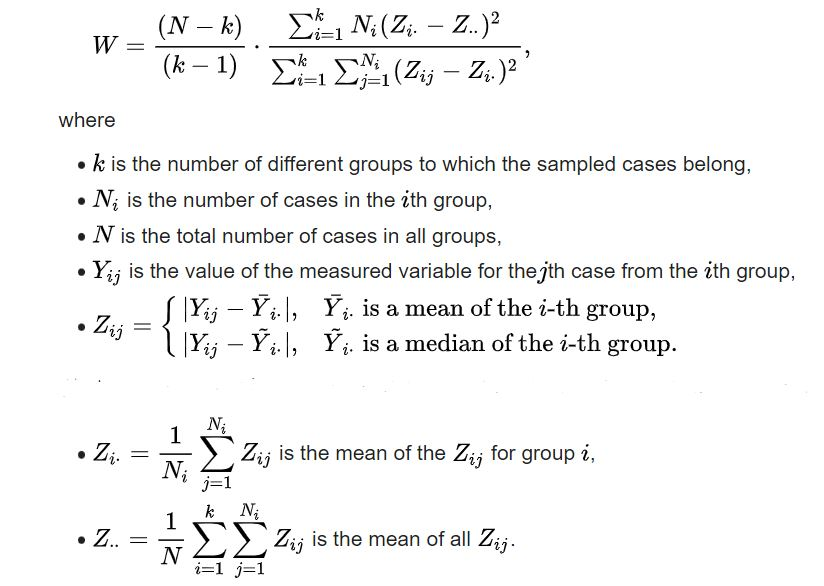

Now, let us see how this test is conducted. I'll use the mock data set from https://datatab.net/tutorial/levene-test to check if the variance between the 3 subjects is the same or not.

In [65]:
import pandas as pd
import numpy as np

# 30 samples of score, with 10 samples for each 3 subgroups (Math, History & Psychology)
data = pd.DataFrame({'Math':[21,23,17,11,9,27,22,12,20,4],
                     'History':[18,22,19,26,13,24,23,17,21,15],
                     'Psychology':[17,16,23,7,26,9,25,21,14,20]})

data.describe()

,Math,History,Psychology
count,10.000000,10.000000,10.000000
mean,16.600000,19.800000,17.800000
std,7.290786,4.131182,6.442912
min,4.000000,13.000000,7.000000
25%,11.250000,17.250000,14.500000
50%,18.500000,20.000000,18.500000
75%,21.750000,22.750000,22.500000
max,27.000000,26.000000,26.000000


In [44]:
print(data.describe().iloc[1,0],
     '\nVariance Math: ', np.var(data['Math']),
     '\nVariance History: ', np.var(data['History']),
     '\nVariance Psychology: ', np.var(data['Psychology']),
     )

16.6 
Variance Math:  47.84 
Variance History:  15.360000000000003 
Variance Psychology:  37.36


If we use the levene test from scipy package, we'll obtain

In [60]:
from scipy.stats import levene

test_stat, p = levene(data['Math'],data['History'],data['Psychology'], center='mean')
print('F-statistic: ', test_stat,
      '\nP-value: ', p)

F-statistic:  2.015940080660649 
P-value:  0.1527571716627755


Which saying that with 97.5% level of confidence, there is not enough evidence to reject the null hypothesis. Thus, there is no difference in the variance of each group.

Now, we'll try to create our own sampling distribution and check if we'll obtain a similar result with the above.

In [98]:
# we are using mean for the levene test

def levene_test(*samples):
    from scipy.stats import f
    k = len(samples)
    lenSam = [len(samples[i]) for i in range(k)]
    grpMean = [np.mean(samples[i]) for i in range(k)]
    Zij = [samples[i] - grpMean[i] for i in range(k)]
    Zij = np.abs(Zij)
    Zij_tot = [np.sum(Zij[i]) for i in range(k)]
    mean_Zi = [np.mean(Zij[i]) for i in range(k)]
    var_Zi = [lenSam[i] * np.var(Zij[i]) for i in range(k)]
    Ntot = np.sum(lenSam)
    mean_Z = np.sum(Zij_tot) / Ntot
            
    numer =  (Ntot - k) * np.sum(lenSam * (mean_Zi - mean_Z)**2, axis=0)
    denom =  (k - 1) * np.sum(var_Zi)
    
    W = numer/denom
       
    pval = 1 - f.cdf(W, k-1, Ntot-k)  # 1 - cdf    
    return W,pval

In [133]:
nsamples = 10000
test_math = np.random.choice(data['Math'], (nsamples,10))
test_hist = np.random.choice(data['History'], (nsamples,10))
test_psych = np.random.choice(data['Psychology'], (nsamples,10))

results = [levene_test(test_math[i], test_hist[i], test_psych[i]) for i in range(nsamples)]
W = [results[i][0] for i in range(nsamples)]
pval = [results[i][1] for i in range(nsamples)]

The W-statistics for levene test will be converged to the F-distributions with degree of freedom (k-1), (N-k) where k is the number of groups being compared and N is the total sample/data being observed.

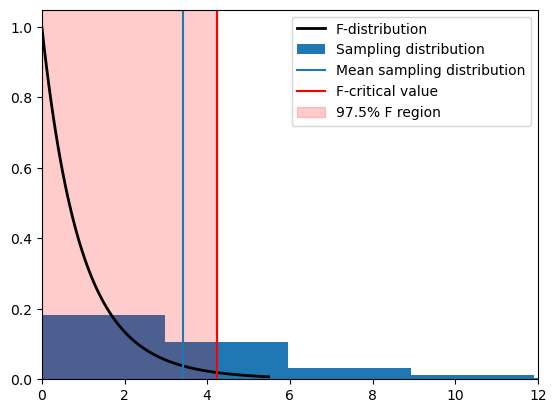

In [149]:
import matplotlib.pyplot as plt
from scipy.stats import f

dfn = 2 # k-1 groups
dfd = 27 # N-k

x = np.linspace(f.ppf(0.001, dfn, dfd), f.ppf(0.99, dfn, dfd), 100)
rv = f(dfn,dfd)

fig, ax = plt.subplots()
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='F-distribution')
ax.hist(W, density=True, label='Sampling distribution')
ax.axvline(np.mean(W), label='Mean sampling distribution')
ax.axvline(f.ppf(0.975, dfn, dfd), color='red', label='F-critical value')
ax.axvspan(0, f.ppf(0.975, dfn, dfd), alpha=0.2, color='red', label='97.5% F region')
ax.set_xlim(0,12)
plt.legend()

And thus completed our simulation for the Levene test for homoscedasticity.